# CNN

<img src="cnnimage.jpg" style="width:1200px;height:400px;">

## Goals:
### 1. Use CNN train on dog vs cat data
### 2. EValuate Model
### 3. Fine tune model

In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.applications.inception_v3 import InceptionV3
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from numpy.random import rand
from keras.callbacks import ModelCheckpoint

# Scikit Imports
from sklearn.model_selection import train_test_split
# Matplot Imports
import matplotlib.pyplot as plt
from keras.models import model_from_json

import seaborn as sns 

Using TensorFlow backend.


In [2]:
# Intialize matplotlib parameters

pd.options.display.max_colwidth = 600


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Get Dataset

The Cats Vs Dogs dataset is available at [Kaggle/Dogbreed](https://www.kaggle.com/c/dogs-vs-cats/data).

The download consists of train, test and label files

In [3]:
train_folder = '/Volumes/My Passport for Mac/data/dogs-vs-cats/train/'
test_folder = '/Volumes/My Passport for Mac/data/dogs-vs-cats/test/'


In [4]:
def getImagesFilePathsFromFolder(path):
    files = []
    #print("path: " + path )
    for f in listdir(path):
        if( isfile(join(path, f)) and (".jpg" in f)) :
            #print("path: " + path)
            #print("file:" + f)
            #print("path + file", os.path.join(path, f))
            files.append(os.path.join(path, f))  
    return files

In [5]:
data_dict = {}
target_labels_list = []
image_path_list = []
counter = 0
fileCounter = 0

walkIterations = 0
print(train_folder)
fileList = getImagesFilePathsFromFolder(train_folder)
for file in fileList:
    label = file.split("/")[-1]
    label = label.split(".")[0]
    image_path = file
    target_labels_list.append(label)
    image_path_list.append(image_path)
    counter = counter + 1
    fileCounter = fileCounter + 1

    
                
data_dict["label"] = target_labels_list            
data_dict["image_path"] = image_path_list
input_df = pd.DataFrame(data_dict)


/Volumes/My Passport for Mac/data/dogs-vs-cats/train/


In [6]:
input_df.describe()


,label,image_path
count,25000,25000
unique,2,25000
top,dog,/Volumes/My Passport for Mac/data/dogs-vs-cats/train/dog.5389.jpg
freq,12500,1


In [7]:
input_df.head()

,label,image_path
0,cat,/Volumes/My Passport for Mac/data/dogs-vs-cats/train/cat.0.jpg
1,cat,/Volumes/My Passport for Mac/data/dogs-vs-cats/train/cat.1.jpg
2,cat,/Volumes/My Passport for Mac/data/dogs-vs-cats/train/cat.10.jpg
3,cat,/Volumes/My Passport for Mac/data/dogs-vs-cats/train/cat.100.jpg
4,cat,/Volumes/My Passport for Mac/data/dogs-vs-cats/train/cat.1000.jpg


## Check Number of Classes in the Dataset

The dataset contain 120 different dog breeds

In [8]:
target_labels = input_df['label']
len(set(target_labels))
print(target_labels[0:5])

0    cat
1    cat
2    cat
3    cat
4    cat
Name: label, dtype: object


### Understand Data

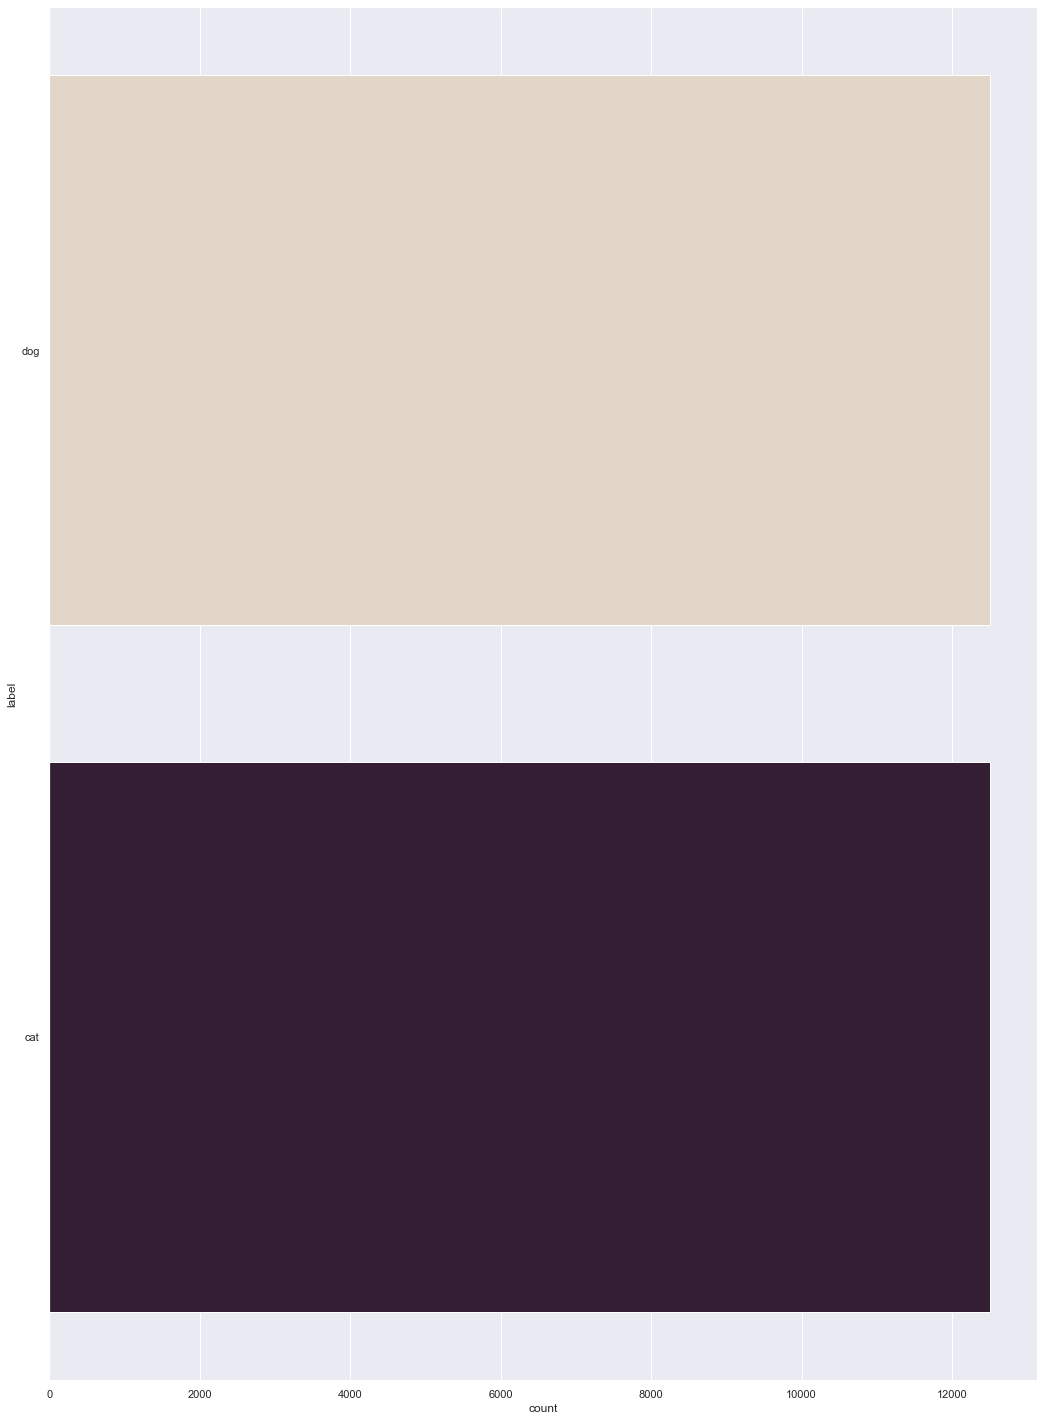

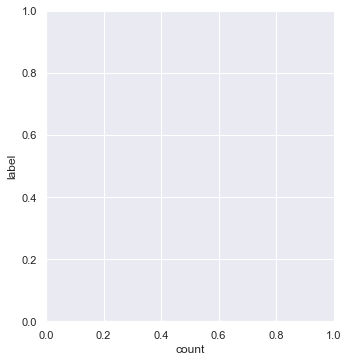

In [9]:
sns.set(style="darkgrid")
sns.set(color_codes=True)
fig, ax = plt.subplots()
fig.set_size_inches(17.7, 25.27)
sns.catplot(y="label",   kind="count", palette="ch:.25",ax=ax, data=input_df, order=input_df.label.value_counts().iloc[:20].index);


In [10]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)

print(labels_ohe_names.shape)
labels_ohe = np.asarray(labels_ohe_names)
labels_ohe_names.to_csv("labels.csv")
print(type(labels_ohe_names))
print(labels_ohe.shape)
print(labels_ohe[0:5])
labels_ohe_names.head()

(25000, 2)
<class 'pandas.core.frame.DataFrame'>
(25000, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


,cat,dog
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


## Prepare Train-Test Datasets
We use a 70-30 split to prepare the two dataset. 

In [11]:
IMG_DIM = (150, 150)
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=IMG_DIM)
                       ) for img 
                           in input_df['image_path'].values.tolist()
                      ]).astype('float32')

In [12]:
train_data.shape

(25000, 150, 150, 3)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [14]:
x_train.shape, x_test.shape

((17500, 150, 150, 3), (7500, 150, 150, 3))

### Prepare Validation Dataset

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [16]:
x_train.shape, x_val.shape

((14875, 150, 150, 3), (2625, 150, 150, 3))

In [17]:
print(y_train.shape)

(14875,)


### Prepare target variables for train, test and validation datasets

In [18]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).as_matrix()
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((14875, 2), (7500, 2), (2625, 2))

## Data Augmentation

Since number of samples per class are not very high, we utilize data augmentation to prepare different variations of different samples available. We do this using the ```ImageDataGenerator utility``` from ```keras```

In [19]:
BATCH_SIZE = 32

In [20]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [21]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

## Prepare Deep Learning Classifier

* Load InceptionV3 pretrained on ImageNet without its top/classification layer
* Add additional custom layers on top of InceptionV3 to prepare custom classifier

(150, 150, 3)


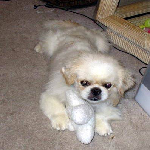

In [22]:
print(x_train[1].shape)
array_to_img(x_train[3])

In [27]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
total_classes = y_train_ohe.shape[1]
model.add(Dense(total_classes, activation='softmax'))
#model.add(Dense(1, activation='sigmoid'))


#predictions = Dense(total_classes, activation='softmax')(out)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

In [24]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model, show_shapes=True, 
#                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [28]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              callbacks=[checkpoint],
                              verbose=True)

Epoch 1/15
464/464 [==============================] - 197s 425ms/step - loss: 0.6451 - accuracy: 0.6240 - val_loss: 0.5513 - val_accuracy: 0.6707

Epoch 00001: val_loss improved from inf to 0.55134, saving model to model-001-0.623998-0.670732.h5
Epoch 2/15
464/464 [==============================] - 197s 425ms/step - loss: 0.5862 - accuracy: 0.6846 - val_loss: 0.5620 - val_accuracy: 0.6830

Epoch 00002: val_loss did not improve from 0.55134
Epoch 3/15
464/464 [==============================] - 197s 425ms/step - loss: 0.5605 - accuracy: 0.7090 - val_loss: 0.5243 - val_accuracy: 0.6799

Epoch 00003: val_loss improved from 0.55134 to 0.52426, saving model to model-003-0.708954-0.679907.h5
Epoch 4/15
464/464 [==============================] - 197s 425ms/step - loss: 0.5419 - accuracy: 0.7240 - val_loss: 0.5624 - val_accuracy: 0.7123

Epoch 00004: val_loss did not improve from 0.52426
Epoch 5/15
464/464 [==============================] - 205s 442ms/step - loss: 0.5293 - accuracy: 0.7329 - va

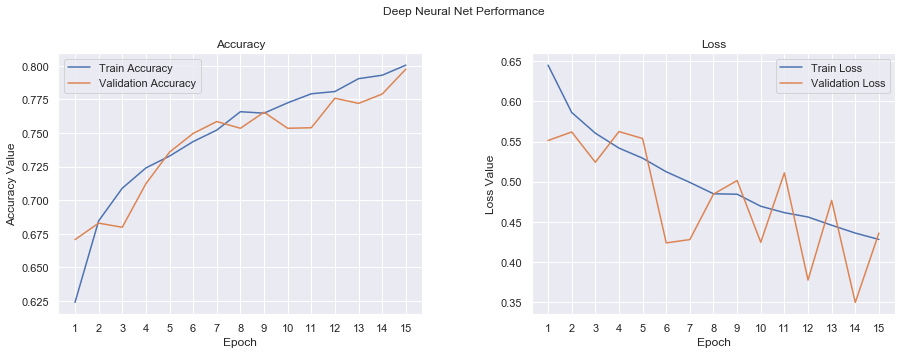

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [34]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(total_classes, activation='softmax'))
#model.add(Dense(1, activation='sigmoid'))


#predictions = Dense(total_classes, activation='softmax')(out)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 128)      

In [35]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              callbacks=[checkpoint],
                              verbose=True)

Epoch 1/15
464/464 [==============================] - 151s 326ms/step - loss: 0.6702 - accuracy: 0.5795 - val_loss: 0.5913 - val_accuracy: 0.6399

Epoch 00001: val_loss improved from inf to 0.59129, saving model to model-001-0.579532-0.639863.h5
Epoch 2/15
464/464 [==============================] - 147s 318ms/step - loss: 0.6109 - accuracy: 0.6663 - val_loss: 0.5507 - val_accuracy: 0.7038

Epoch 00002: val_loss improved from 0.59129 to 0.55070, saving model to model-002-0.666307-0.703818.h5
Epoch 3/15
464/464 [==============================] - 146s 315ms/step - loss: 0.5682 - accuracy: 0.7012 - val_loss: 0.3604 - val_accuracy: 0.7146

Epoch 00003: val_loss improved from 0.55070 to 0.36039, saving model to model-003-0.701206-0.714616.h5
Epoch 4/15
464/464 [==============================] - 149s 322ms/step - loss: 0.5419 - accuracy: 0.7263 - val_loss: 0.5838 - val_accuracy: 0.7304

Epoch 00004: val_loss did not improve from 0.36039
Epoch 5/15
464/464 [==============================] - 15

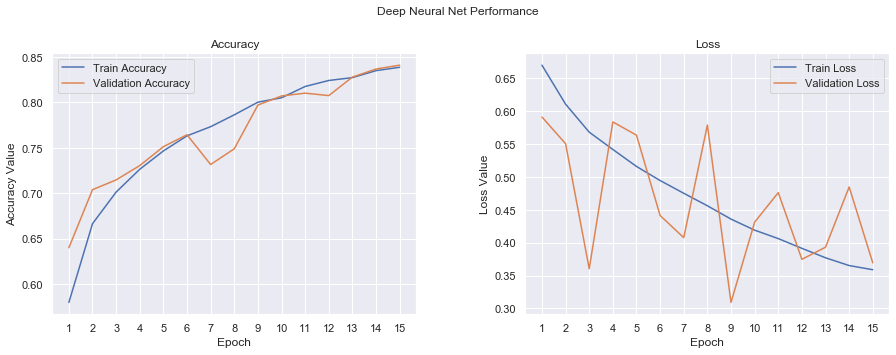

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [37]:
model.save('cats_dogs_basic_cnn.h5')

## Test Model Performance

Step 1 is to prepare the training dataset. Since we scaled training data, test data should also be scaled in a similar manner. 

_Note: Deep Learning models are very sensitive to scaling._

In [38]:
# scaling test features
x_test /= 255.

In [39]:
test_predictions = model.predict(x_test)
test_predictions

array([[0.133854  , 0.86614597],
       [0.05914894, 0.94085103],
       [0.07031436, 0.9296857 ],
       ...,
       [0.3612689 , 0.6387311 ],
       [0.42578194, 0.57421803],
       [0.668006  , 0.33199397]], dtype=float32)

In [40]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,cat,dog
0,0.133854,0.866146
1,0.059149,0.940851
2,0.070314,0.929686
3,0.689495,0.310505
4,0.047847,0.952153


In [41]:
def get_x_test(img_path, img_height, img_width):
    return np.array([img_to_array(load_img(img_path, target_size=(img_height, img_width)))]).astype('float32')


In [42]:
def predict(x_test, model):
    #x_test = kimage.resize(image, 299, 299) 
    x_test /= 255.0
    test_predictions = model.predict(x_test)
    predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
    predictions = list(predictions.idxmax(axis=1))
    return predictions
    

In [43]:
def getImagesFilePathsFromFolder(path):
    onlyfiles = [ join(path,f) for f in listdir(path) if ( isfile(join(path, f)) and (".jpg" in f) )]
    return onlyfiles

In [44]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog']

### Save Model to disk

In [45]:
MODEL_JSON_PATH = "/Volumes/My Passport for Mac/model/dogs-vs-cats.json"
MODEL_H5_PATH = "/Volumes/My Passport for Mac/model/dogs-vs-cats.h5"


# serialize model to JSON
model_json = model.to_json()
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_H5_PATH)
print("Saved model to disk")

Saved model to disk


### Load model from disk

In [46]:
# load json and create model
json_file = open(MODEL_JSON_PATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_H5_PATH)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 


Loaded model from disk


### Load test images and test predictions

In [ ]:
path = "/Volumes/My Passport for Mac/data/dogs-vs-cats/test/"
fileCount = len(getImagesFilePathsFromFolder(path)) 
#print(getImagesFilePathsFromFolder(path))
fig, ax = plt.subplots(1,fileCount, figsize=(50,50))
img_Counter=0;

for img_path in getImagesFilePathsFromFolder(path):
    print(img_path)
    breed = predict(get_x_test(img_path, 150, 150), loaded_model)[0]
    print(breed)
    ax[img_Counter].set_title(breed)
    ax[img_Counter].imshow(load_img(img_path, target_size=(150, 150)))
    img_Counter = img_Counter + 1



## Analyze Test Performance

In [ ]:
import model_evaluation_utils as meu

In [ ]:
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

In [ ]:
meu.display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(labels_ohe_names.columns))

In [ ]:
meu.display_confusion_matrix(true_labels=test_labels, 
                                    predicted_labels=predictions, 
                                    classes=list(labels_ohe_names.columns))

## Visualize Model Performance
Visualize model performance with actual images, labels and prediction confidence

In [ ]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)    